In [1]:
import numpy as np
vmin = 0
vmax=1
levels=np.linspace(vmin,vmax,21)
import os
import sys
import re
import pandas as pd
import scipy
import csv
import matplotlib.pyplot as plt
from matplotlib.mlab import griddata
import seaborn.apionly as sns
from matplotlib import cm
import glob
import matplotlib
matplotlib.rcParams['axes.edgecolor'] = 'black'
matplotlib.rcParams['axes.linewidth'] = 1
import statistics
from scipy.stats import sem
from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split
import matplotlib.colors as mcolors
tum_blue4_as_python_color = np.array([0, 82, 147]) / 255
cmap = sns.light_palette(tum_blue4_as_python_color, as_cmap=True)
beads = ["C0433","C0434","C0435"]
from matplotlib.colors import LinearSegmentedColormap
cmap1 = LinearSegmentedColormap.from_list("my_colormap", ((0, 0, 0), (1, 1, 1)), N=6, gamma=1.0)
cmap = mcolors.LinearSegmentedColormap.from_list(name='red_white_blue', 
                                                 colors =[(0, 0, 1), 
                                                          (1, 1., 1), 
                                                          (1, 0, 0)],
                                                 N=len(levels)-1,
                                                 )
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import time
from scipy import interp
import pickle
from scipy.stats import ttest_ind
from pylab import *
import matplotlib.colors as colors
# functions
def create_colour_lists():
    '''
    Converts several lists of rgb colours to the python format (normalized to between 0 and 1)
    Returns a dictionary that contains dictionaries of palettes with named colours (eg. TUM blues)
    and also lists of unnamed colours (e.g. tableau20)
    (copied from tlabtools 2016.08.08)
    '''
    output_dict = {}

    matplotlib_150 = list(colors.cnames.values())
    output_dict['matplotlib_150'] = matplotlib_150

    #define colour dictionaries. TUM colours are based on the style guide.
    colour_dicts = {
                    'TUM_colours' : {
                                    'TUMBlue':(34,99,169),
                                    'TUM1':(100,160,200),
                                    'TUM2':(1,51,89),
                                    'TUM3':(42,110,177),
                                    'TUM4':(153,198,231),
                                    'TUM5':(0,82,147)
                                    },
                    'TUM_oranges': {
                        'TUM0': (202, 101, 10),
                        'TUM1': (213, 148, 96),
                        'TUM2': (102, 49, 5),
                        'TUM3': (220, 108, 11),
                        'TUM4': (247, 194, 148),
                        'TUM5': (160, 78, 8)
                    },
                    'TUM_accents' : {
                                    'green':(162,183,0),
                                    'orange':(227,114,34),
                                    'ivory':(218,215,203),
                                    }
                    }

    #convert the nested dicts to python 0 to 1 format
    for c_dict in colour_dicts:
        for c in colour_dicts[c_dict]:
            #define r, g, b as ints
            r, g, b = colour_dicts[c_dict][c]
            #normalise r, g, b and add to dict
            colour_dicts[c_dict][c] = (r / 255., g / 255., b / 255.)
        #add normalised colours to output dictionary
        output_dict[c_dict] = colour_dicts[c_dict]

    #define colour lists
    colour_lists = {
                    'tableau20' : [
                                 (31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
                                 (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
                                 (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
                                 (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
                                 (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)
                                    ],
                    'tableau20blind' : [
                                         (0, 107, 164), (255, 128, 14), (171, 171, 171), (89, 89, 89),
                                         (95, 158, 209), (200, 82, 0), (137, 137, 137), (163, 200, 236),
                                         (255, 188, 121), (207, 207, 207)
                                          ]
                    }
    #normalise the colours for the colour lists
    for rgb_list in colour_lists:
        colour_array = np.array(colour_lists[rgb_list])/255.
        colour_array_tup = tuple(map(tuple,colour_array))
        colour_lists[rgb_list] = colour_array_tup
        #add normalised colours to output dictionary
        output_dict[rgb_list] = colour_lists[rgb_list]
    #create a mixed blue/grey colour list, with greys in decreasing darkness
    TUM_colours_list_with_greys = []
    grey = 0.7
    for c in colour_dicts['TUM_colours'].values():
        TUM_colours_list_with_greys.append('%0.2f' % grey)
        TUM_colours_list_with_greys.append(c)
        grey -= 0.1
    output_dict['TUM_colours_list_with_greys'] = TUM_colours_list_with_greys

    output_dict['HTML_list01'] = ['#808080', '#D59460', '#005293', '#A1B11A', '#9ECEEC', '#0076B8', '#454545', "#7b3294", "#c2a5cf", "#008837", "#a6dba0"]
    return output_dict

def read_concat_wells(i,well,perc,df_out):
    df_file = r"Well_{}_Raw.csv".format(well)
    df = pd.read_csv(df_file, sep=';', decimal=',', skiprows=7,encoding="latin1")
    live_accuracy = 0
    dead_accuracy = 0
    live_accuracy, dead_accuracy = pi_accuracy(live_accuracy_list,dead_accuracy_list,well,perc,df)
    if i == 0:
        df["live"] = 1
    if i == 1:
        df["live"] = 0
    if df_out.empty:
        df_out = df
    else:
        df_out = pd.concat([df_out,df])
    return df_out, live_accuracy, dead_accuracy

def concat_df(df_all,df):
    if df_all.empty:
        df_all = df
    else:
        df_all = pd.concat([df_all,df])
    return df_all

def pi_accuracy(live_accuracy_list,dead_accuracy_list,well,perc,df):
    df['PopID'] = df['PopID'].str.replace(',','.')
    df['PopID'] = df['PopID'].str.replace('#INF','000')
    df['PopID'] = df['PopID'].str.replace('#IND00','000')
    df['PopID'] = pd.to_numeric(df['PopID'])
    threshold = -1
    live_accuracy = 0
    dead_accuracy = 0
    if perc == "100":
        live_accuracy = df[df['PopID'] < threshold].shape[0]/df.shape[0]
    if perc == "0":
        dead_accuracy = df[df['PopID'] > threshold].shape[0]/df.shape[0]
    return live_accuracy, dead_accuracy
    

    
def change_german_to_english_name(df):
    german_features = ['Gesamtfläche [Pixel]', 'Algendurchmesser [µm]','Maximaler Radius [Pixel]','Minimaler Radius [Pixel]','Formfaktor MaxRad/MinRad',
            'Kodierung1_Achteck',
           'Kodierung1_Hintergrund', 'Kodierung1_Achteck/Belichtungszeit-normiert',
           'Kodierung1_Achteck/Größen-Belichtungszeit-normiert',
           'Kodierung2_Achteck',
           'Kodierung2_Hintergrund', 'Kodierung2_Achteck/Belichtungszeit-normiert',
           'Kodierung2_Achteck/Größen-Belichtungszeit-normiert', 'PopID']
    english_features = ['Total_area', 'Diameter','Maximal_radius','Minimal_radius','Minimal/maximal_radius',
            'Syto9_fluo',
           'Syto9_background', 'Syto9_fluo_time_norm',
           'Syto9_fluo_size_norm',
           'PI_fluo',
           'PI_background', 'PI_fluo_time_norm',
           'PI_fluo_size_norm', 'Syto9_fluo/PI_fluo']
    for i,feature in enumerate(german_features):
        if feature in  df:
            df.rename(columns={feature:english_features[i]},inplace=True)
    return df

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


ModuleNotFoundError: No module named 'tpot'

## Main videoscan fluorescence data parameters
1. diameter in µm (called “Durchmesser”)
2. area in pixel (called “Gesamtfläche”)
3. form factor (called “Formfaktor”) a number describing the roundness of the particle = the ratio of the max. radius and the min. radius of the object
4. fluorescence signals 1 and 2 (called “Kodierung 1” und “Kodierung 2”), For all viability assays with VideoScan the Syto 9 staining should be signal 1 and PI should be signal 2
5. PopID = logarithmic ratio between the two fluorescence signals


## Positive and negative wells
1.  Live_dead_data_01_15  
    A1,B1,C1,F3,G3,H3(positive,all living)  
    H5,A6,B6,C3,D3,E3(negative,all dead)  
2. Live_dead_data_01_16  
    E6,F6,G6,B9,C9,D9(positive,all living)  
    G8,H8,A9,G8,H8,A9(negative,all dead)  

In [8]:
#videoscan data directory
vs_dir = r"C:\Users\zengb\PycharmProjects\AlgeaClass\Data\VideoScan"
#all features, morphology and fluorescence signal features together,the last feature 'live'
#represents the cell live or dead status.
features = ['Gesamtfläche [Pixel]', 'Algendurchmesser [µm]','Maximaler Radius [Pixel]','Minimaler Radius [Pixel]','Formfaktor MaxRad/MinRad',
        'Kodierung1_Achteck',
       'Kodierung1_Hintergrund', 'Kodierung1_Achteck/Belichtungszeit-normiert',
       'Kodierung1_Achteck/Größen-Belichtungszeit-normiert',
       'Kodierung2_Achteck',
       'Kodierung2_Hintergrund', 'Kodierung2_Achteck/Belichtungszeit-normiert',
       'Kodierung2_Achteck/Größen-Belichtungszeit-normiert', 'PopID','live']
#only mophology features
features1 = ['Gesamtfläche [Pixel]', 'Algendurchmesser [µm]','Maximaler Radius [Pixel]','Minimaler Radius [Pixel]','Formfaktor MaxRad/MinRad',
        'live']
#two experiment dataset directories
dirs = [
       os.path.join(vs_dir,"Live_dead_data_01_16"),
       os.path.join(vs_dir,"Live_dead_data_01_15")
       ]
pstv_wells_list = [["E6","F6","G6", "B9","C9","D9"],["A1","B1","C1", "F3","G3","H3"]]
ngtv_wells_list = [["G8","H8","A9","D11","E11","F11"],["C3","D3","E3","H5","A6","B6"]]
pec80_wells_list = [["H6","A7","B7","E9","F9","G9"],["D1","E1","F1","A4","B4","C4"]]
pec60_wells_list = [["C7","D7","E7","H9","A10","B10"],["G1","H1","A2","D4","E4","F4"]]
pec50_wells_list = [["F7","G7","H7","C10","D10","E10"],["B2","C2","D2","G4","H4","A5"]]
pec40_wells_list = [["A8","B8","C8","F10","G10","H10"],["E2","F2","G2","B5","C5","D5"]]
pec20_wells_list = [["D8","E8","F8","A11","B11","C11"],["H2","A3","B3","E5","F5","G5"]]
df_all_all = pd.DataFrame()
df_pstv_all = pd.DataFrame()
df_ngtv_all = pd.DataFrame()
df_80_all = pd.DataFrame()
df_60_all = pd.DataFrame()
df_50_all = pd.DataFrame()
df_40_all = pd.DataFrame()
df_20_all = pd.DataFrame()
df0 = pd.DataFrame()
live_accuracy_list = []
dead_accuracy_list = []
for i, dir in enumerate(dirs):
    os.chdir(dir)
    pstv_wells = pstv_wells_list[i]
    ngtv_wells = ngtv_wells_list[i]
    pec80_wells = pec80_wells_list[i]
    pec60_wells = pec60_wells_list[i]
    pec50_wells = pec50_wells_list[i]
    pec40_wells = pec40_wells_list[i]
    pec20_wells = pec20_wells_list[i]
    wells_list = [pstv_wells_list[i],ngtv_wells_list[i],pec80_wells_list[i],pec60_wells_list[i],pec50_wells_list[i]
            ,pec40_wells_list[i],pec20_wells_list[i]]
    perc_list = ["100","0","80","60","50","40","20"]
    df_pstv = pd.DataFrame()
    df_ngtv = pd.DataFrame()
    df_all = pd.DataFrame()
    df_80 = pd.DataFrame()
    df_60 = pd.DataFrame()
    df_50 = pd.DataFrame()
    df_40 = pd.DataFrame()
    df_20 = pd.DataFrame()
    df_out_list = [df_pstv,df_ngtv,df_80,df_60,df_50,df_40,df_20]
    for j,wells in enumerate(wells_list):
        for well in wells:
            df_out_list[j], live_accuracy, dead_accuracy = read_concat_wells(j,well,perc_list[j],df_out_list[j])
            live_accuracy_list.append(live_accuracy)
            dead_accuracy_list.append(dead_accuracy)
    df_pstv,df_ngtv,df_80,df_60,df_50,df_40,df_20 = df_out_list  
#     df_pstv = df_pstv[df_pstv.PopID < -1.0]
#     df_ngtv = df_ngtv[df_ngtv.PopID > -1.0]
    df_all = pd.concat([df_pstv,df_ngtv])
    df_all = df_all[features]
    df_pstv_all = concat_df(df_pstv_all,df_pstv)
    df_ngtv_all = concat_df(df_ngtv_all,df_ngtv)
    df_all_all = concat_df(df_all_all,df_all)
    df_80_all = concat_df(df_80_all,df_80)
    df_60_all = concat_df(df_60_all,df_60)
    df_50_all = concat_df(df_50_all,df_50)
    df_40_all = concat_df(df_40_all,df_40)
    df_20_all = concat_df(df_20_all,df_20)
    df_80_all,df_60_all,df_50_all,df_40_all,df_20_all = [df_80_all[features[0:-1]],df_60_all[features[0:-1]],df_50_all[features[0:-1]]
                                                         ,df_40_all[features[0:-1]],df_20_all[features[0:-1]]]
os.chdir(vs_dir)
print(df_all_all.shape)
df_all_all,df_pstv_all,df_ngtv_all,df_80_all,df_60_all,df_50_all,df_40_all,df_20_all = [change_german_to_english_name(df) \
                for df in [df_all_all,df_pstv_all,df_ngtv_all,df_80_all,df_60_all,df_50_all,df_40_all,df_20_all]]
df_all_all_pkl = os.path.join("df_all_all.pkl")
with open(df_all_all_pkl, "wb") as f:
    pickle.dump(df_all_all, f, protocol=pickle.HIGHEST_PROTOCOL)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:147: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



(90617, 15)


In [13]:
# df_all_morph_pkl = os.path.join("df_all_morph.pkl")
# with open(df_all_morph_pkl, "wb") as f:
#     pickle.dump(df_all_all, f, protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
##training the classifier and run cross-validation
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve

df_all_all = df_all_all[df_all_all['Diameter']<7.5]
df_all_all['pred'] = 0
X = df_all_all.drop(['live','pred'], 1)
y = df_all_all['live']
skf = StratifiedKFold(n_splits=10)
cv = list(skf.split(X, y))
n_features = X.shape[1]
min_samples_leaf=5
min_samples_split=12
max_depth=30
max_features=3
random_state=42
crossvalidation_pkl = os.path.join("10F_dat_all.pkl")
# features_csv = os.path.join("test_features_all.csv")
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
# save all outputs to a cross-validation dictionary, to be saved as a pickle file
xv_dict = {}
# forest = ExtraTreesClassifier(n_estimators=200, n_jobs=4, criterion="entropy",
#                                         min_samples_leaf=min_samples_leaf,
#                                         min_samples_split = min_samples_split,
#                                         max_depth=max_depth,
#                                         max_features=max_features,
#                                         random_state=random_state
#                                         )
# forest = ExtraTreesClassifier(bootstrap=True, criterion="entropy", max_features=0.8, min_samples_leaf=4, min_samples_split=20, n_estimators=100)
forest = ExtraTreesClassifier(bootstrap=True, criterion="entropy", max_features=0.8, min_samples_leaf=4, min_samples_split=20, n_estimators=100)
start = time.perf_counter()
accuracy_list = []
for i, (train, test) in enumerate(cv):
    sys.stdout.write("f{}.".format(i + 1)), sys.stdout.flush()
    probas_ = forest.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
    binaris_ = forest.fit(X.iloc[train], y.iloc[train]).predict(X.iloc[test])
    precision, recall, thresholds_PRC = precision_recall_curve(y.iloc[test], binaris_)
    df_all_all['pred'].iloc[test]= binaris_
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1], drop_intermediate=False)
    tn, fp, fn, tp = confusion_matrix(y.iloc[test], binaris_).ravel()
#                 print(tp,tn,fp,fn)
    accuracy = (tn+tp)/(tn+fp+fn+tp)
    accuracy_list.append(accuracy)
    xv_dict["fpr{}".format(i)] = fpr
    xv_dict["tpr{}".format(i)] = tpr
    xv_dict["precision{}".format(i)] = precision
    xv_dict["recall{}".format(i)] = recall
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
sys.stdout.write("\n"), sys.stdout.flush()
sys.stdout.write("tree depths : {}".format([estimator.tree_.max_depth for estimator in forest.estimators_]))

duration = time.perf_counter() - start

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0

mean_auc = auc(mean_fpr, mean_tpr)
mean_acc = mean(accuracy_list)

xv_dict["true_positive_rate_mean"] = mean_tpr
xv_dict["false_positive_rate_mean"] = mean_fpr
xv_dict["mean_auc"] = mean_auc

# save dict as pickle
with open(crossvalidation_pkl, "wb") as f:
    pickle.dump(xv_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

features_ser = pd.Series(X.columns)
# features_ser.to_csv(features_csv)
sys.stdout.write('10-fold validation. AUC({:.3f}). mean accuracy :{}. Time taken = {:.2f}.\nFeatures: {}'.format( mean_auc,mean_acc,
                                                                                             duration,X.columns.tolist()))

f1.f2.

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


f3.

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


f4.

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


f5.

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


f6.

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


f7.

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


f8.

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


f9.

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


f10.

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)



tree depths : [29, 25, 26, 26, 28, 28, 29, 26, 25, 26, 25, 25, 24, 23, 25, 27, 28, 29, 28, 28, 24, 27, 32, 26, 26, 27, 24, 25, 24, 25, 24, 23, 26, 25, 25, 26, 27, 27, 28, 27, 22, 25, 24, 28, 26, 25, 28, 25, 27, 24, 28, 29, 23, 26, 29, 24, 30, 28, 28, 24, 31, 27, 25, 29, 25, 27, 23, 24, 25, 29, 26, 27, 28, 24, 26, 28, 29, 26, 27, 27, 26, 28, 31, 24, 29, 28, 27, 24, 27, 27, 23, 25, 26, 26, 25, 27, 32, 28, 25, 28]10-fold validation. AUC(0.989). mean accuracy :0.9603207348306823. Time taken = 99.80.
Features: ['Total_area', 'Diameter', 'Maximal_radius', 'Minimal_radius', 'Minimal/maximal_radius', 'Syto9_fluo', 'Syto9_background', 'Syto9_fluo_time_norm', 'Syto9_fluo_size_norm', 'PI_fluo', 'PI_background', 'PI_fluo_time_norm', 'PI_fluo_size_norm', 'Syto9_fluo/PI_fluo']

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


-0.3999999999999999

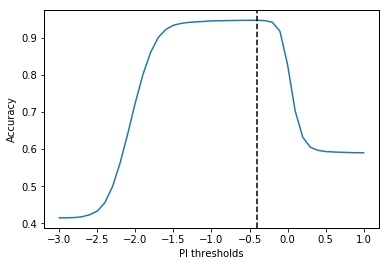

In [17]:
## get the optimal threshold for the PI mehtod
import numpy as np
df_all_all = df_all_all[df_all_all['Diameter']<7.5]
tls =np.linspace(-3,1,41)
error_list = []
fig,ax = plt.subplots()
for tl in tls:
    fn = df_all_all[(df_all_all['Syto9_fluo/PI_fluo']<tl) & (df_all_all['live']==0)].shape[0]
    fp = df_all_all[(df_all_all['Syto9_fluo/PI_fluo']>tl) & (df_all_all['live']==1)].shape[0]
    error = (df_all_all.shape[0]-fn-fp)/df_all_all.shape[0]
    error_list.append(error)
#     print(tl,error)
ax.plot(tls,error_list)
ax.axvline(x=tls[error_list.index(max(error_list))],linestyle = '--',color='black')
plt.xlabel("PI thresholds")
plt.ylabel("Accuracy")
tls[error_list.index(max(error_list))]
# plt.savefig("D:\Ronny_Proj\Results\Optimal_threshold.png")
# plt.savefig("D:\Ronny_Proj\Results\Optimal_threshold.pdf")

(745, 16)
(1474, 16)


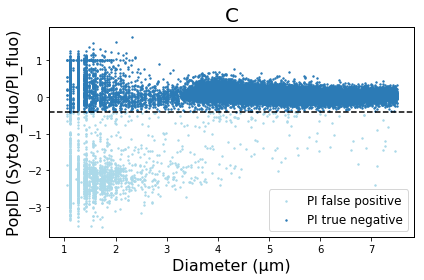

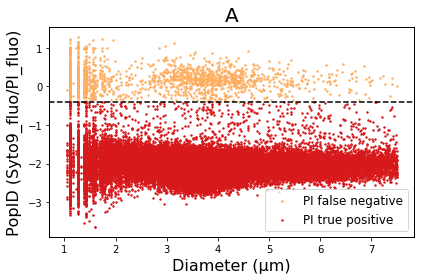

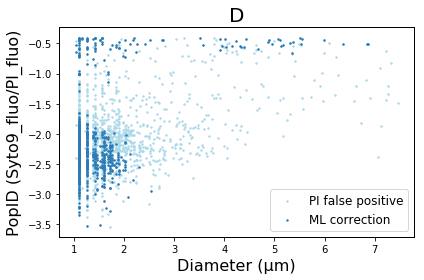

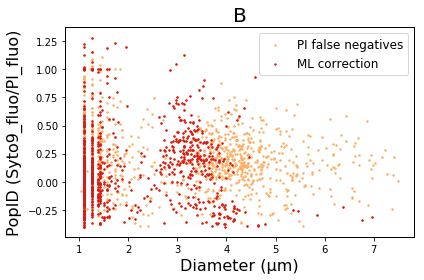

In [18]:
fig, ax = plt.subplots()
ax.scatter(np.array(df_all_all[(df_all_all['Syto9_fluo/PI_fluo']<-0.4) & (df_all_all['live']==0)]['Diameter']), \
           np.array(df_all_all[(df_all_all['Syto9_fluo/PI_fluo']<-0.4) & (df_all_all['live']==0)]['Syto9_fluo/PI_fluo']),s=2,c="#abd9e9",label='PI false positive')
ax.scatter(np.array(df_all_all[(df_all_all['Syto9_fluo/PI_fluo']>-0.4) & (df_all_all['live']==0)]['Diameter']), \
           np.array(df_all_all[(df_all_all['Syto9_fluo/PI_fluo']>-0.4) & (df_all_all['live']==0)]['Syto9_fluo/PI_fluo']),c='#2c7bb6',s=2,label='PI true negative')
axhline(y=-0.4,color = 'black',linestyle = '--')
plt.xlabel("Diameter (µm)",fontsize=16)
plt.ylabel("PopID (Syto9_fluo/PI_fluo)",fontsize=16)
plt.title("C",fontsize=20)
ax.legend(loc="lower right",fontsize=12)
plt.tight_layout()
# plt.savefig("D:\Ronny_Proj\Results\ScatterplotC.png")
# plt.savefig("D:\Ronny_Proj\Results\ScatterplotC.pdf")
fig, ax = plt.subplots()
ax.scatter(np.array(df_all_all[(df_all_all['Syto9_fluo/PI_fluo']>-0.4) & (df_all_all['live']==1)]['Diameter']), \
           np.array(df_all_all[(df_all_all['Syto9_fluo/PI_fluo']>-0.4) & (df_all_all['live']==1)]['Syto9_fluo/PI_fluo']),s=2,c="#fdae61",label='PI false negative')
ax.scatter(np.array(df_all_all[(df_all_all['Syto9_fluo/PI_fluo']<-0.4) & (df_all_all['live']==1)]['Diameter']), \
           np.array(df_all_all[(df_all_all['Syto9_fluo/PI_fluo']<-0.4) & (df_all_all['live']==1)]['Syto9_fluo/PI_fluo']),c='#d7191c',s=2,label='PI true positive')
axhline(y=-0.4,color = 'black',linestyle = '--')
plt.xlabel("Diameter (µm)",fontsize=16)
plt.ylabel("PopID (Syto9_fluo/PI_fluo)",fontsize=16)
plt.title("A",fontsize=20)
ax.legend(loc="lower right",fontsize=12)
plt.tight_layout()
plt.savefig("D:\Ronny_Proj\Results\ScatterplotA.png")
plt.savefig("D:\Ronny_Proj\Results\ScatterplotA.pdf")
df_all_all[(df_all_all['Syto9_fluo/PI_fluo']<-1.0) & (df_all_all['live']==0)][['live','pred']]
fig, ax = plt.subplots()
ax.scatter(np.array(df_all_all[(df_all_all['Syto9_fluo/PI_fluo']<-0.4) & (df_all_all['live']==0)]['Diameter']), \
           np.array(df_all_all[(df_all_all['Syto9_fluo/PI_fluo']<-0.4) & (df_all_all['live']==0)]['Syto9_fluo/PI_fluo']),s=2,c="#abd9e9",label='PI false positive')
ax.scatter(np.array(df_all_all[(df_all_all['Syto9_fluo/PI_fluo']<-0.4) & (df_all_all['live']==0) & (df_all_all['pred']==0)]['Diameter']), \
           np.array(df_all_all[(df_all_all['Syto9_fluo/PI_fluo']<-0.4) & (df_all_all['live']==0) & (df_all_all['pred']==0)]['Syto9_fluo/PI_fluo']),c='#2c7bb6',s=2,label='ML correction')
plt.xlabel("Diameter (µm)",fontsize=16)
plt.ylabel("PopID (Syto9_fluo/PI_fluo)",fontsize=16)
plt.title("D",fontsize=20)
ax.legend(loc="lower right",fontsize=12)
print(df_all_all[(df_all_all['Syto9_fluo/PI_fluo']<-0.4) & (df_all_all['live']==0) & (df_all_all['pred']==0)].shape)
print(df_all_all[(df_all_all['Syto9_fluo/PI_fluo']<-0.4) & (df_all_all['live']==0) & (df_all_all['pred']==1)].shape)
plt.tight_layout()
# plt.savefig("D:\Ronny_Proj\Results\ScatterplotD.png")
# plt.savefig("D:\Ronny_Proj\Results\ScatterplotD.pdf")
df_all_all[(df_all_all['Syto9_fluo/PI_fluo']<-1.0) & (df_all_all['live']==0)][['live','pred']]
fig, ax = plt.subplots()
ax.scatter(np.array(df_all_all[(df_all_all['Syto9_fluo/PI_fluo']>-0.4) & (df_all_all['live']==1)]['Diameter']), \
           np.array(df_all_all[(df_all_all['Syto9_fluo/PI_fluo']>-0.4) & (df_all_all['live']==1)]['Syto9_fluo/PI_fluo']),s=2,c="#fdae61",label='PI false negatives')
ax.scatter(np.array(df_all_all[(df_all_all['Syto9_fluo/PI_fluo']>-0.4) & (df_all_all['live']==1) & (df_all_all['pred']==1)]['Diameter']), \
           np.array(df_all_all[(df_all_all['Syto9_fluo/PI_fluo']>-0.4) & (df_all_all['live']==1) & (df_all_all['pred']==1)]['Syto9_fluo/PI_fluo']),c='#d7191c',s=2,label='ML correction')
plt.xlabel("Diameter (µm)",fontsize=16)
plt.ylabel("PopID (Syto9_fluo/PI_fluo)",fontsize=16)
plt.title("B",fontsize=20)
ax.legend(loc="upper right",fontsize=12)
plt.tight_layout()
# plt.savefig("D:\Ronny_Proj\Results\ScatterplotB.png")
# plt.savefig("D:\Ronny_Proj\Results\ScatterplotB.pdf")

In [19]:
def get_liverperc(df,cutoff):
    livenum = df[(df['Syto9_fluo/PI_fluo']<cutoff)].shape[0]
    deadnum = df[(df['Syto9_fluo/PI_fluo']>=cutoff)].shape[0]
    liveperc = livenum/(livenum+deadnum)
    return liveperc
for df in [df_ngtv_all,df_20_all,df_40_all,df_50_all,df_60_all,df_80_all,df_pstv_all]:
    liveperc = get_liverperc(df,-0.4)
    print(liveperc)

0.00541629598618452
0.2570909862542145
0.46725282229667725
0.5152055688492495
0.6337892624595601
0.8210046833900045
1.0


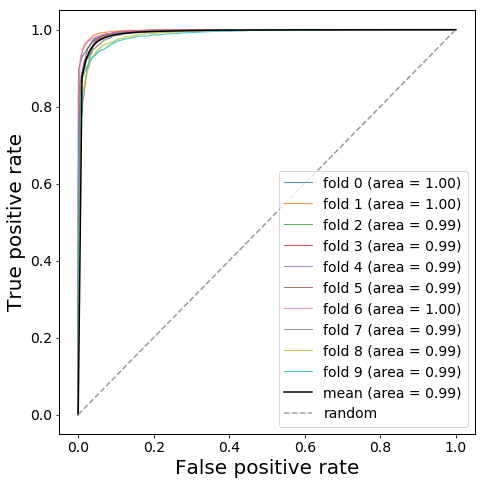

In [19]:
##plot the cross validation plots
crossvalidation_png = os.path.join("10F_ROC_morph.png")
crossvalidation_pdf = os.path.join("10F_ROC_morph.pdf")
with open(crossvalidation_pkl, "rb") as f:
    xv_dict = pickle.load(f)

figsize = np.array([3.42, 3.42]) * 2  # DOUBLE the real size
fig, ax = plt.subplots(figsize=figsize)
for i in range(10):
    roc_auc = auc(xv_dict["fpr{}".format(i)], xv_dict["tpr{}".format(i)])
    ax.plot(xv_dict["fpr{}".format(i)], xv_dict["tpr{}".format(i)], lw=1, label='fold %d (area = %0.2f)' % (i, roc_auc), alpha=0.8)

mean_auc = xv_dict["mean_auc"]

ax.plot(xv_dict["false_positive_rate_mean"], xv_dict["true_positive_rate_mean"], color="k",
        label='mean (area = %0.2f)' % mean_auc, lw=1.5)

ax.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='random')
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel("False positive rate",fontsize = 20)
ax.set_ylabel("True positive rate",fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(loc="lower right",fontsize = 14)
fig.tight_layout()
fig.savefig(crossvalidation_png, dpi=240)
fig.savefig(crossvalidation_pdf, dpi=240)
fig.savefig(crossvalidation_png[:-4] + ".pdf")
# fig.savefig(MiRMAK.utils.pdf_subpath(crossvalidation_png))

1. feature 13 (0.235340) Syto9_fluo/PI_fluo2. feature 11 (0.149977) PI_fluo_time_norm3. feature 9 (0.119090) PI_fluo4. feature 5 (0.117397) Syto9_fluo5. feature 7 (0.083934) Syto9_fluo_time_norm6. feature 12 (0.079876) PI_fluo_size_norm7. feature 8 (0.059397) Syto9_fluo_size_norm8. feature 6 (0.040652) Syto9_background9. feature 1 (0.030445) Diameter10. feature 3 (0.025832) Minimal_radius



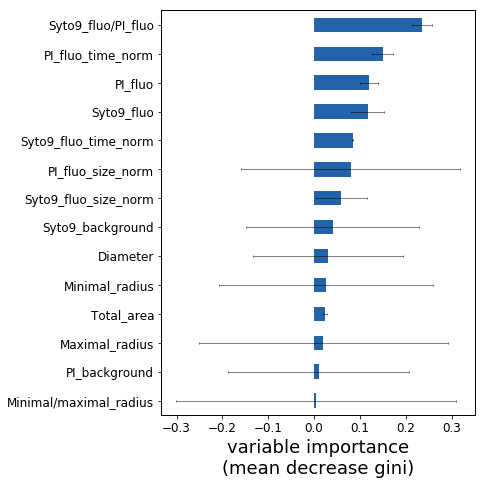

In [20]:
## plot the variable importances
variable_importance_csv = os.path.join("variable_importance.csv")
variable_importance_png = os.path.join("var_import_morph.png")
variable_importance_pdf = os.path.join("var_import_morph.pdf")
importances_arr = forest.feature_importances_
std_arr = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices_arr = np.argsort(importances_arr)[::-1]

importances_text_list = X.columns.tolist()
output_dfs = []
#order_list = [importances_arr[indices_arr[f]] for f in range(X.shape[1])]
nested_dict = {}
for f in range(X.shape[1]):
    if f < 10 :
        sys.stdout.write("%d. feature %d (%f) %s" % (f + 1, indices_arr[f], importances_arr[indices_arr[f]], importances_text_list[indices_arr[f]]))
    single_feature_dict = {"original_order" : indices_arr[f], "mean_decrease_gini" : importances_arr[indices_arr[f]], "feature" : importances_text_list[indices_arr[f]],  "std" : std_arr[f]}
    nested_dict[f + 1] = single_feature_dict

sys.stdout.write("\n\n"), sys.stdout.flush()
df_imp = pd.DataFrame(nested_dict).T
df_imp["order_importance"] = df_imp.index
#df_imp.set_index("feature", inplace=True)
df_imp.set_index("original_order", inplace=True)
output_dfs.append(df_imp)
df_imp2 = pd.concat(output_dfs, axis=1)
df_imp2.sort_values("order_importance", inplace=True)
df_imp2["original_order"] = df_imp2.index
df_imp2.set_index("feature", inplace=True)
df_imp2.to_csv(variable_importance_csv)
df_imp = pd.read_csv(variable_importance_csv, index_col = 0)
n_features_in_plot = df_imp.shape[0]
df_sel = df_imp.iloc[:n_features_in_plot, :].copy()
df_sel.sort_values("mean_decrease_gini", ascending=True, inplace=True)
plot_height = 4 * n_features_in_plot / 30
figsize = np.array([3.42, 3.42]) * 2
fig, ax = plt.subplots(figsize=figsize)
colour_dict = create_colour_lists()
TUMblue = colour_dict["TUM_colours"]['TUMBlue']
df_sel["mean_decrease_gini"].plot(kind="barh", color=TUMblue, ax=ax)# xerr=df_sel["std"]
ax.errorbar(df_sel["mean_decrease_gini"], range(len(df_sel.index)), xerr=df_sel["std"], fmt="none", ecolor="k", ls="none", capthick=0.5, elinewidth=0.5, capsize=1, label=None)

ax.set_ylabel("")
ax.set_xlabel("variable importance\n(mean decrease gini)", fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(False)
fig.tight_layout()
fig.savefig(variable_importance_png, dpi=240)
fig.savefig(variable_importance_pdf, dpi=240)

r_value 0.9950026947272407 and p_value 0.00042375210132940434
r_value 0.9872868628901946 and p_value 0.001717445767258794


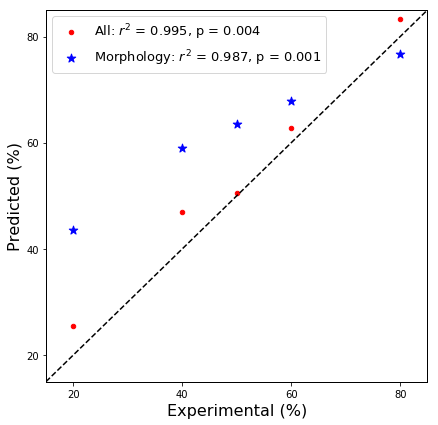

In [21]:
# ##ratio pred using all features
# ratio_pred = [0.8321892175103184,0.6280560219501208,0.5059386556449859,0.46885336861648774,0.25426166505552544]
# ##ratio pred using only morphology features
# ratio_pred = [0.7672419323795471, 0.677832835087432, 0.6350881009353927, 0.5903455045989031, 0.43635206186782355]
ratio_pred_all = [0.8321892175103184,0.6280560219501208,0.5059386556449859,0.46885336861648774,0.25426166505552544]
ratio_pred_mor = [0.7672419323795471, 0.677832835087432, 0.6350881009353927, 0.5903455045989031, 0.43635206186782355]
ratio_exp = [0.8,0.6,0.5,0.4,0.2]
xticks=[0.0,0.2,0.4,0.6,0.8,1.0]
yticks=[0.0,0.2,0.4,0.6,0.8,1.0]
r_value1,p_value1 = scipy.stats.pearsonr(ratio_exp, ratio_pred_all)
r_value2,p_value2 = scipy.stats.pearsonr(ratio_exp, ratio_pred_mor)
print("r_value {} and p_value {}".format(r_value1,p_value1))
print("r_value {} and p_value {}".format(r_value2,p_value2))
exp_pred_ratio_png = "Experiment_predict_live_dead_ratio_all.png"
exp_pred_ratio_pdf = "Experiment_predict_live_dead_ratio_all.pdf"
figsize = np.array([3.42, 3.42]) * 2 # DOUBLE the real size, due to problems on Bo computer with fontsizes
fig, ax = plt.subplots(figsize=figsize)
ax.plot(xticks,yticks,'--k')
ax.scatter(ratio_exp,ratio_pred_all,marker='.',color='red',s=80,label="All: $r^2$ = 0.995, p = 0.004")
ax.scatter(ratio_exp,ratio_pred_mor,marker='*',color='blue',s=80,label="Morphology: $r^2$ = 0.987, p = 0.001")
ax.set(yticks=[0.0,0.2,0.4,0.6,0.8,1.0])
ax.set_yticklabels(['0','20','40','60','80','100'])
ax.set_ylabel("Predicted (%)", fontsize=16)
ax.set_xlabel("Experimental (%)", fontsize=16)
ax.set(xticks=[0.0,0.2,0.4,0.6,0.8,1.0])
ax.set_xticklabels(['0','20','40','60','80','100'])
ax.set_xlim(0.15,0.85)
ax.set_ylim(0.15,0.85)
# plt.text(0.1,0.9,"Association coefficent is %.3f\nP value is %.4f" % (r_value,p_value),fontsize=14)
ax.legend(fontsize=13)
plt.savefig(exp_pred_ratio_png)
plt.savefig(exp_pred_ratio_pdf)

# plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


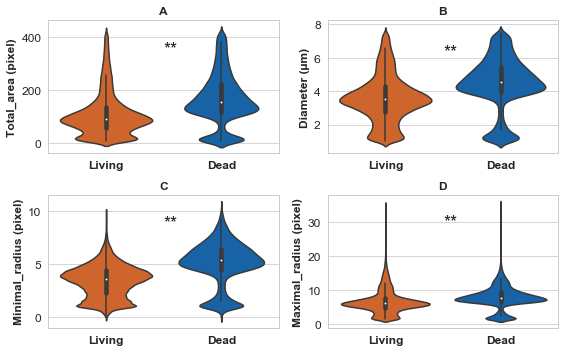

In [22]:
# df_pstv_all.columns
df_pstv_all = df_pstv_all[df_pstv_all['Diameter']<7.5]
df_ngtv_all = df_ngtv_all[df_ngtv_all['Diameter']<7.5]
df_violin = pd.DataFrame()
df_pstv_all['status'] = 'Living'
df_ngtv_all['status'] = 'Dead'
df_violin = pd.concat([df_pstv_all,df_ngtv_all])
morphs = ['Total_area','Diameter','Minimal_radius', 'Maximal_radius']
names = ['Total_area (pixel)','Diameter (µm)','Minimal_radius (pixel)', 'Maximal_radius (pixel)']
titles =['A','B','C','D']
color_1 = '#E95D12'
color_2 = '#0065BD'
color_3 = '#99C5E6'
# figure_size = 3.46 * 3.46
fig, axes = plt.subplots(figsize= (8, 5))
violin_plot_all_png = r"D:\Ronny_Proj\Results\All_mophorlogy.png"
violin_plot_all_pdf = r"D:\Ronny_Proj\Results\All_mophorlogy.pdf"
i=0
sns.set_style("whitegrid")
for name, morph in zip(names,morphs):
    ax = plt.subplot(2, 2,i+1)
#     violin_plot_png = r"D:\Ronny_Proj\Results\{}_mophorlogy.png".format(name)
    sns.violinplot(x = 'status',y=morph,data=df_violin,palette=[color_1,color_2])
    plt.ylabel(name,fontsize=12,fontweight='bold')
#     xlabel(fontsize=10,fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=12)
    plt.xlabel('')
    plt.title(titles[i],fontweight='bold')
    plt.text(0.5,max(df_ngtv_all[morph])*0.8,"**",fontsize = 18)
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontweight('bold')
    plt.tight_layout()
    i = i+1
#     plt.savefig(violin_plot_png)     
#     plt.show()

plt.savefig(violin_plot_all_png)
plt.savefig(violin_plot_all_pdf)

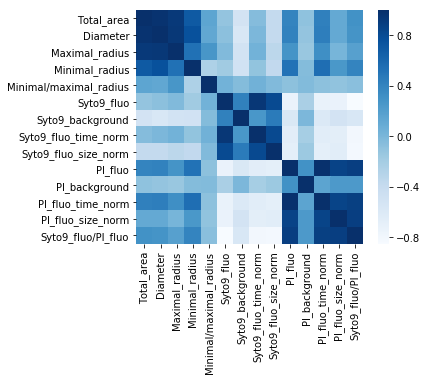

In [54]:
import seaborn as sns
# df_all_all =df_all_all.drop(['live','pred'],1)
corr = df_all_all.corr()
fig, ax = plt.subplots(figsize=(6.8,5.8))
g = sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
               cmap="Blues")
# g.set_yticklabels(g.get_yticklabels(), rotation = 15) 
# g.set_xticklabels( g.get_xticklabels(),rotation = 15) 
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=45)
# ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
# ax.set_yticklabels(ax.get_yticklabels(), rotation = 45)
# plt.tight_layout()
plt.gcf().subplots_adjust(bottom=0.32)
plt.gcf().subplots_adjust(left=0.32)
# plt.savefig(r'D:\Ronny_Proj\Algae VideoScan raw data\live_dead_staining_defined_ratios_of_living_and_dead_algae\HeatMapCorr.png')
# plt.savefig(r'D:\Ronny_Proj\Algae VideoScan raw data\live_dead_staining_defined_ratios_of_living_and_dead_algae\HeatMapCorr.pdf')
plt.show()


In [26]:
pstv_wells_list = [["E6","F6","G6", "B9","C9","D9"],["A1","B1","C1", "F3","G3","H3"]]
ngtv_wells_list = [["G8","H8","A9","D11","E11","F11"],["C3","D3","E3","H5","A6","B6"]]
df_all_all = pd.DataFrame()
live_accuracy_list = []
dead_accuracy_list = []
for i, dir in enumerate(dirs):
    os.chdir(dir)
    pstv_wells = pstv_wells_list[i]
    ngtv_wells = ngtv_wells_list[i]
    wells_list = [pstv_wells_list[i],ngtv_wells_list[i]]
    perc_list = ["100","0"]
    df_pstv = pd.DataFrame()
    df_ngtv = pd.DataFrame()
    df_all = pd.DataFrame()
    df_out_list = [df_pstv,df_ngtv]
    for j,wells in enumerate(wells_list):
        for well in wells:
            df_out_list[j], live_accuracy, dead_accuracy = read_concat_wells(j,well,perc_list[j],df_out_list[j])
            live_accuracy_list.append(live_accuracy)
            dead_accuracy_list.append(dead_accuracy)
    df_pstv,df_ngtv = df_out_list  
#     df_pstv = df_pstv[df_pstv.PopID < -1.0]
#     df_ngtv = df_ngtv[df_ngtv.PopID > -1.0]
    df_all = pd.concat([df_pstv,df_ngtv])
    df_all = df_all[features]
    df_pstv_all = concat_df(df_pstv_all,df_pstv)
    df_ngtv_all = concat_df(df_ngtv_all,df_ngtv)
    df_all_all = concat_df(df_all_all,df_all)
    
os.chdir(vs_dir)
print(df_all_all.shape)
df_all_all,df_pstv_all,df_ngtv_all = [change_german_to_english_name(df) \
                for df in [df_all_all,df_pstv_all,df_ngtv_all]]
df_all_morph_pkl = os.path.join("df_all_morph.pkl")
with open(df_all_morph_pkl, "wb") as f:
    pickle.dump(df_all_all, f, protocol=pickle.HIGHEST_PROTOCOL)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:147: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



(90617, 15)


In [27]:
X = df_all_all.drop('live', 1)
y = df_all_all['live']

# digits = load_digits()
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.75, test_size=0.25)
X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)
tpot = TPOTClassifier(generations=5, population_size=20, verbosity=2)
tpot.fit(X_train, y_train)
# print(tpot.score(X_test, y_test))
# tpot.export('tpot_mnist_pipeline.py')

ModuleNotFoundError: No module named 'tpot'

In [ ]:
### compared 7 classifiers for live/dead algea classification
from sklearn.metrics import confusion_matrix
names = ["Nearest Neighbors", 
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

X = df_all_all.drop('live', 1)
y = df_all_all['live']
skf = StratifiedKFold(n_splits=10)
cv = list(skf.split(X, y))
n_features = X.shape[1]
for name, clf in zip(names, classifiers):
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    accuracy_list = []
    recall_list =[]
    precision_list = []
    for i, (train, test) in enumerate(cv):
        sys.stdout.write("f{}.".format(i + 1)), sys.stdout.flush()
        probas_ = clf.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
        binaris_ = clf.fit(X.iloc[train], y.iloc[train]).predict(X.iloc[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1], drop_intermediate=False)
        tn, fp, fn, tp = confusion_matrix(y.iloc[test], binaris_).ravel()
        accuracy = (tn+tp)/(tn+fp+fn+tp)
        print(tp,tn,fp,fn)
        accuracy_list.append(accuracy)
        recall = tp/(fn+tp)
        precision = tp/(fp+tp)
        recall_list.append(recall)
        precision_list.append(precision)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
    mean_tpr /= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    mean_acc = mean(accuracy_list)
    mean_precision = mean(precision_list)
    mean_recall = mean(recall_list)
    sys.stdout.write('{} 10-fold validation. AUC({:.3f}). mean accuracy :{}. \n mean precision {}. mean recall {}'.format(name, mean_auc,mean_acc,mean_precision,mean_recall))
